# Computing $\pi$ in Parallel with Markov Chain Monte Carlo (MCMC) and

MPI

[Sam Foreman](https://samforeman.me)
(\[[ALCF](https://alcf.anl.gov/about/people/sam-foreman)\](<https://alcf.anl.gov/about/people/sam-foreman>))  
2025-07-15

[![](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/saforem2/intro-hpc-bootcamp-2025/blob/main/docs/00-intro-AI-HPC/5-mcmc-example/index.ipynb)

> **Parallel Computing**
>
> **Parallel computing** refers to the process of breaking down larger
> problems into smaller, independent, often similar parts that can be
> executed simultaneously by multiple processors communicating via
> network or shared memory, the results of which are combined upon
> completion as part of an overall algorithm.

## Example: Estimate $\pi$

We can calculate the value of $\pi$ using a MPI parallelized version of
the Monte Carlo method. The basic idea is to estimate $\pi$ by randomly
sampling points within a square and determining how many fall inside a
quarter circle inscribed within that square.

<figure>
<img
src="https://www.101computing.net/wp/wp-content/uploads/estimating-pi-monte-carlo-method.png"
alt="\pi" />
<figcaption aria-hidden="true"><span
class="math inline"><em>π</em></span></figcaption>
</figure>

The ratio between the area of the circle and the square is

$$\frac{N_\text{in}}{N_\text{total}} = \frac{\pi r^2}{4r^2} = \frac{\pi}{4}$$

Therefore, we can calculate $\pi$ using
$\pi = \frac{4N_\text{in}}{N_\text{total}}$

In [1]:
import ambivalent

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use(ambivalent.STYLES['ambivalent'])
sns.set_context("notebook")
plt.rcParams["figure.figsize"] = [6.4, 4.8]

from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import numpy as np
import random
import time

import ezpz
from rich import print

[2025-08-01 16:55:36,785842][I][ezpz/__init__:265:ezpz] Setting logging level to 'INFO' on 'RANK == 0'                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

Pi = 3.264

Time: 19.813298225402832

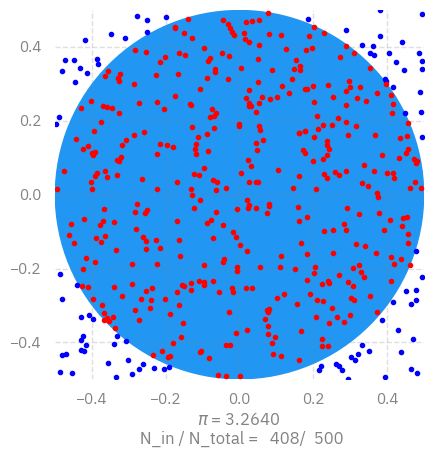

In [2]:
fig, ax = plt.subplots()
#ax = fig.add_subplot(111)
circle = plt.Circle(( 0. , 0. ), 0.5 )
plt.xlim(-0.5, 0.5)
plt.ylim(-0.5, 0.5)
ax.add_patch(circle)
ax.set_aspect('equal')
N = 500
Nin = 0
t0 = time.time()
for i in range(1, N+1):
    x = random.uniform(-0.5, 0.5)
    y = random.uniform(-0.5, 0.5)
    if (np.sqrt(x*x + y*y) < 0.5):
        Nin += 1
        plt.plot([x], [y], 'o', color='r', markersize=3)
    else:
        plt.plot([x], [y], 'o', color='b', markersize=3)
    display(fig)
    plt.xlabel("$\pi$ = %3.4f \n N_in / N_total = %5d/%5d" %(Nin*4.0/i, Nin, i))
    clear_output(wait=True)

res = np.array(Nin, dtype='d')
t1 = time.time()
print(f"Pi = {res/float(N/4.0)}")
print("Time: %s" %(t1 - t0))

### MPI example

| Nodes  | PyTorch-2.5 | PyTorch-2.7 | PyTorch-2.8 |
|:------:|:-----------:|:-----------:|:-----------:|
| N1xR12 |    17.39    |    31.01    |    33.09    |
| N2xR12 |    3.81     |    32.71    |    33.26    |

In [3]:
from mpi4py import MPI
import numpy as np
import random
import time
comm = MPI.COMM_WORLD

N = 5000000
Nin = 0
t0 = time.time()
for i in range(comm.rank, N, comm.size):
    x = random.uniform(-0.5, 0.5)
    y = random.uniform(-0.5, 0.5)
    if (np.sqrt(x*x + y*y) < 0.5):
        Nin += 1
res = np.array(Nin, dtype='d')
res_tot = np.array(Nin, dtype='d')
comm.Allreduce(res, res_tot, op=MPI.SUM)
t1 = time.time()
if comm.rank==0:
    print(res_tot/float(N/4.0))
    print("Time: %s" %(t1 - t0))

3.1396984

Time: 2.912393093109131

In [4]:
! mpirun -np 1 --allow-run-as-root python mpi_pi.py

In [5]:
! mpirun -np 2 --allow-run-as-root --oversubscribe python mpi_pi.py

In [6]:
! mpirun -np 4 --allow-run-as-root --oversubscribe python mpi_pi.py

### Running $\pi$ on Polaris

``` bash
ssh <username>@polaris.alcf.anl.gov
qsub -A ALCFAITP -l select=1 -q ALCFAITP -l walltime=0:30:00 -l filesystems=home:eagle
# choose debug queue outside of the class
# qsub -A ALCFAITP -l select=1 -q debug -l walltime=0:30:00 -l filesystems=home:eagle

module load conda/2023-10-04
conda activate /soft/datascience/ALCFAITP/2023-10-04
git clone git@github.com:argonne-lcf/ai-science-training-series.git
cd ai-science-training-series/01_intro_AI_on_Supercomputer/
mpirun -np 1 python mpi_pi.py   # 3.141988,   8.029037714004517  s
mpirun -np 2 python mpi_pi.py   # 3.1415096   4.212774038314819  s
mpirun -np 4 python mpi_pi.py   # 3.1425632   2.093632459640503  s
mpirun -np 8 python mpi_pi.py   # 3.1411632   1.0610620975494385 s
```

## Parallel computing in AI

The parallel computing in AI is usually called distributed training.

Distributed training is the process of training I models across multiple
GPUs or other accelerators, with the goal of speeding up the training
process and enabling the training of larger models on larger datasets.

There are two ways of parallelization in distributed training.

-   **Data parallelism**:
    -   Each worker (GPU) has a complete set of model
    -   different workers work on different subsets of data.
-   **Model parallelism**
    -   The model is splitted into different parts and stored on
        different workers
    -   Different workers work on computation involved in different
        parts of the model

<figure id="fig-parallel-computing">
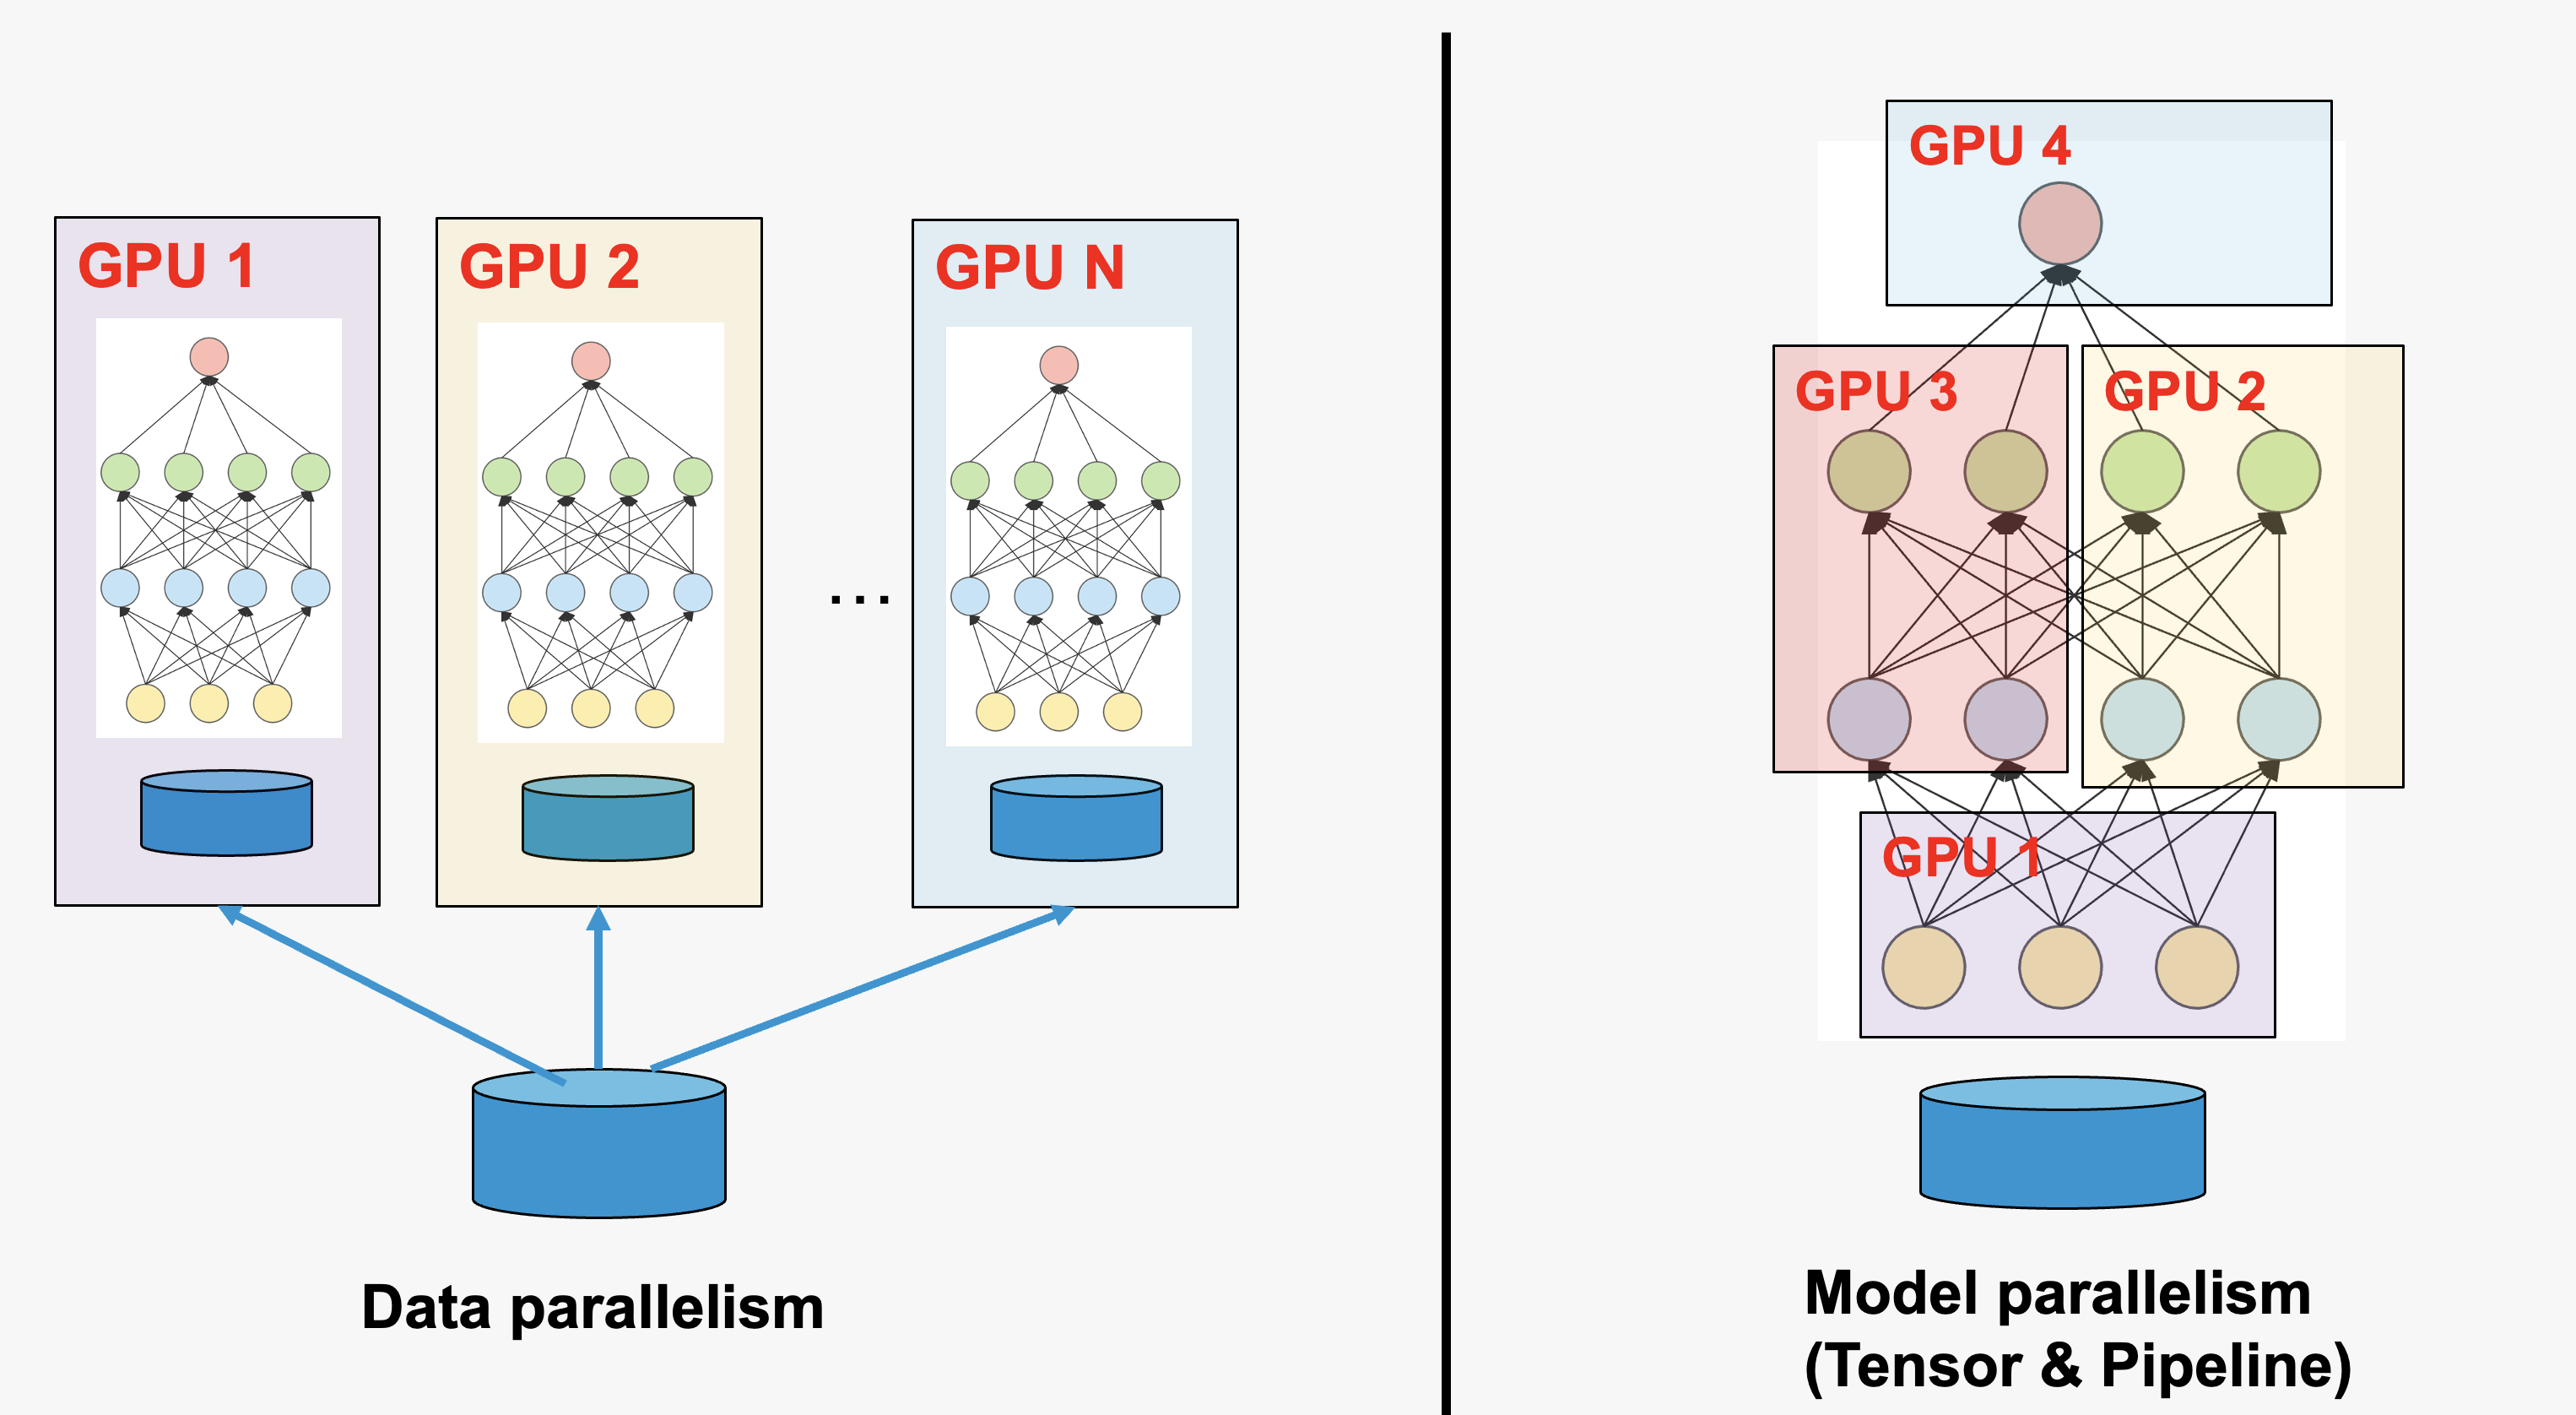
<figcaption>Figure 1: PI</figcaption>
</figure>

<figure id="fig-3dllm">
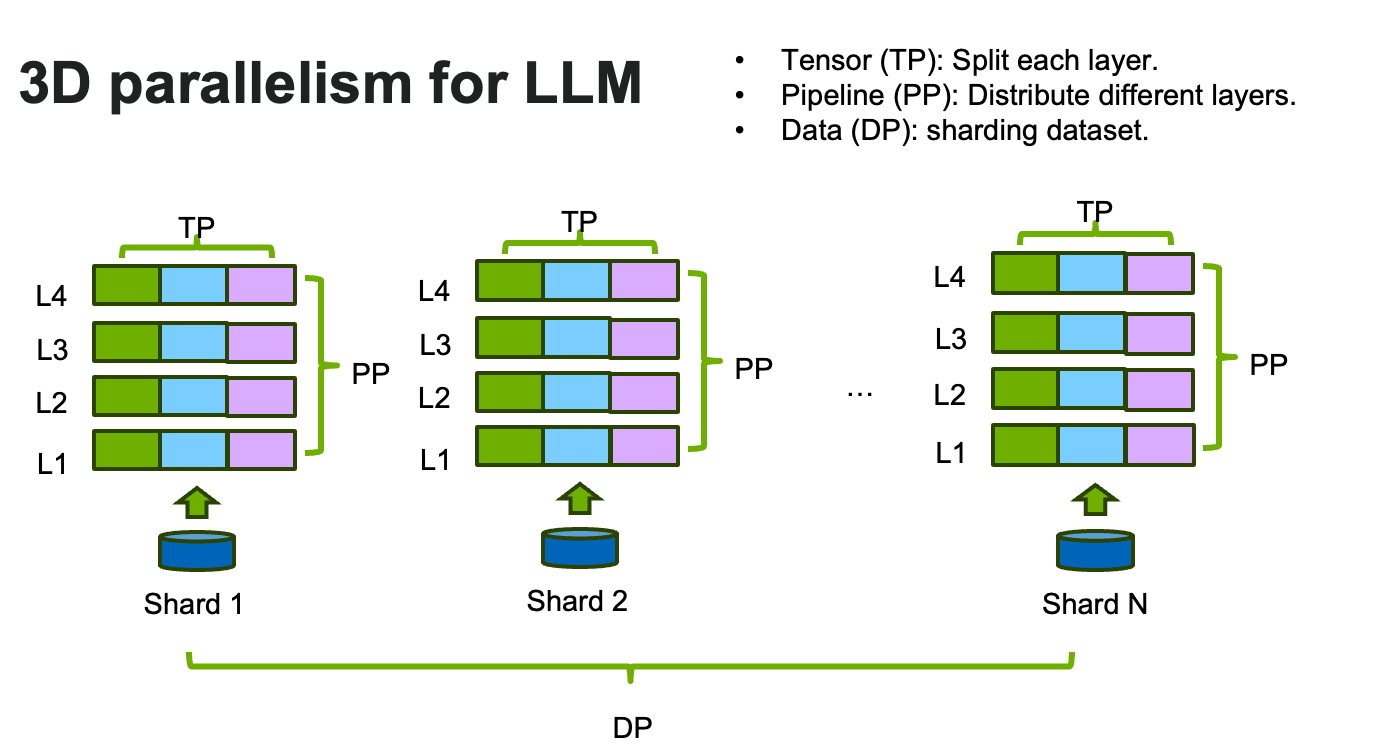
<figcaption>Figure 2: 3D LLM</figcaption>
</figure>